In [1]:
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [7]:
def q_stat(r):
    q = []
    for i in range(r.shape[0]):
        q.append(np.matmul(r[i], r[i].T))
    return np.array(q)

In [2]:
def get_pca_components(num_features=6):
    healthy_filepath = 'data/healthy.csv'
    healthy = np.genfromtxt(healthy_filepath, delimiter=',')[:, :num_features]
    mean = np.mean(healthy, axis=0)
    std = np.std(healthy, axis=0)
    healthy_n = (healthy - mean) / std

    pca = PCA(n_components=num_features, svd_solver='full')
    pca.fit(healthy_n)

    return pca.components_

In [5]:
num_features = 6
healthy_filepath = 'data/healthy.csv'
healthy = np.genfromtxt(healthy_filepath, delimiter=',')[:, :num_features]

beams = ['a6', 'a17', 'a18']
damages = [f'd{i}' for i in range(10, 91, 10)]

train_ratio = 0.6
val_ratio = 0.2

train_idx = int(train_ratio * healthy.shape[0])
val_idx = int((train_ratio + val_ratio) * healthy.shape[0])

train = healthy[:train_idx, :]
mean = np.mean(train, axis=0)
std = np.std(train, axis=0)
train_n = (train - mean) / std

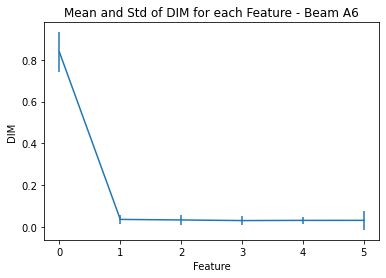

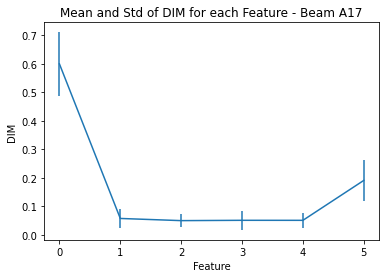

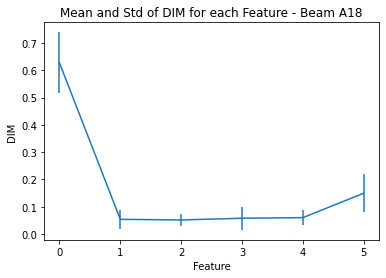

In [14]:
n_pc = 1
pca = PCA(n_components=n_pc, svd_solver='full')
pca.fit(train_n)

dims_mean, dims_std = [], []
for beam in beams:
    # defective data for "beam"
    q_val_defective, val_defective_n = [], []
    for damage in damages:
        defective_filepath = f'data/{beam}/{beam}_{damage}.csv'
        defective = np.genfromtxt(defective_filepath, delimiter=',')[:, :num_features]

        val_defective = defective[train_idx:val_idx, :]
        val_defective_n.append((val_defective - mean) / std)

        val_defective_recons_n = pca.inverse_transform(pca.transform((val_defective - mean) / std))

        q_val_defective.append(q_stat(val_defective_recons_n - (val_defective - mean) / std))

    q_val_defective = np.concatenate(q_val_defective, axis=0)
    val_defective_n = np.concatenate(val_defective_n, axis=0)

    # DIM analysis
    q_0 = q_val_defective

    delta_qs = []
    for f in range(val_defective_n.shape[1]):
        min_r = np.min(val_defective_n[:, f])
        max_r = np.max(val_defective_n[:, f])
        increment = (max_r - min_r) / 100
        val_defective_plus_n = val_defective_n.copy()
        val_defective_minus_n = val_defective_n.copy()
        for i in range(val_defective_n.shape[0]):
            val_defective_plus_n[i, f] += increment
            val_defective_minus_n[i, f] -= increment
        val_defective_plus_n_recons = pca.inverse_transform(pca.transform(val_defective_plus_n))
        val_defective_minus_n_recons = pca.inverse_transform(pca.transform(val_defective_minus_n))
        residual_val_defective_plus_n = val_defective_plus_n_recons - val_defective_plus_n
        residual_val_defective_minus_n = val_defective_minus_n_recons - val_defective_minus_n
        q_plus = q_stat(residual_val_defective_plus_n)
        q_minus = q_stat(residual_val_defective_minus_n)
        q = np.maximum(q_plus, q_minus)
        delta_q = q - q_0
        delta_qs.append(delta_q)
    delta_qs = np.array(delta_qs).T
    delta_qs_sum = np.sum(delta_qs, axis=1)
    dim = []
    for i in range(delta_qs.shape[0]):
        dim.append(delta_qs[i, :] / delta_qs_sum[i])
    dim = np.array(dim)

    dims_mean.append(np.mean(dim, axis=0))
    dims_std.append(np.std(dim, axis=0))

for dim_mean, dim_std, beam in zip(dims_mean, dims_std, beams):
    plt.figure()
    plt.errorbar(range(dim_mean.shape[0]), dim_mean, dim_std)
    plt.xlabel('Feature')
    plt.ylabel('DIM')
    plt.title(f'Mean and Std of DIM for each Feature - Beam {beam.upper()}')
    plt.show()

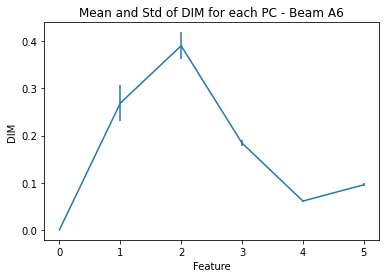

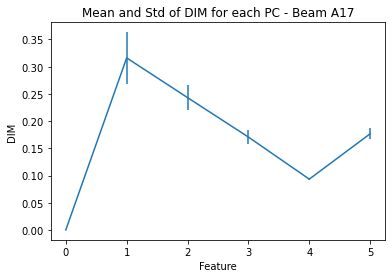

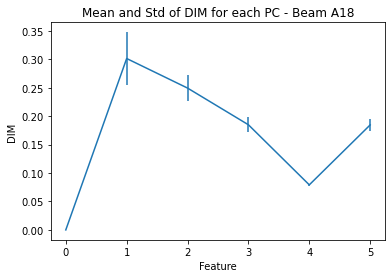

In [15]:
pca_1 = PCA(n_components=num_features, svd_solver='full')
train_n = pca_1.fit_transform(train_n)

n_pc = 1
pca = PCA(n_components=n_pc, svd_solver='full')
pca.fit(train_n)

dims_mean_pc, dims_std_pc = [], []
for beam in beams:
    # defective data for "beam"
    q_val_defective, val_defective_n = [], []
    for damage in damages:
        defective_filepath = f'data/{beam}/{beam}_{damage}.csv'
        defective = np.genfromtxt(defective_filepath, delimiter=',')[:, :num_features]
        defective = pca_1.transform(defective)

        val_defective = defective[train_idx:val_idx, :]
        val_defective_n.append((val_defective - mean) / std)

        val_defective_recons_n = pca.inverse_transform(pca.transform((val_defective - mean) / std))

        q_val_defective.append(q_stat(val_defective_recons_n - (val_defective - mean) / std))

    q_val_defective = np.concatenate(q_val_defective, axis=0)
    val_defective_n = np.concatenate(val_defective_n, axis=0)

    # DIM analysis
    q_0 = q_val_defective

    delta_qs = []
    for f in range(val_defective_n.shape[1]):
        min_r = np.min(val_defective_n[:, f])
        max_r = np.max(val_defective_n[:, f])
        increment = (max_r - min_r) / 100
        val_defective_plus_n = val_defective_n.copy()
        val_defective_minus_n = val_defective_n.copy()
        for i in range(val_defective_n.shape[0]):
            val_defective_plus_n[i, f] += increment
            val_defective_minus_n[i, f] -= increment
        val_defective_plus_n_recons = pca.inverse_transform(pca.transform(val_defective_plus_n))
        val_defective_minus_n_recons = pca.inverse_transform(pca.transform(val_defective_minus_n))
        residual_val_defective_plus_n = val_defective_plus_n_recons - val_defective_plus_n
        residual_val_defective_minus_n = val_defective_minus_n_recons - val_defective_minus_n
        q_plus = q_stat(residual_val_defective_plus_n)
        q_minus = q_stat(residual_val_defective_minus_n)
        q = np.maximum(q_plus, q_minus)
        delta_q = q - q_0
        delta_qs.append(delta_q)
    delta_qs = np.array(delta_qs).T
    delta_qs_sum = np.sum(delta_qs, axis=1)
    dim = []
    for i in range(delta_qs.shape[0]):
        dim.append(delta_qs[i, :] / delta_qs_sum[i])
    dim = np.array(dim)

    dims_mean_pc.append(np.mean(dim, axis=0))
    dims_std_pc.append(np.std(dim, axis=0))

for dim_mean, dim_std, beam in zip(dims_mean_pc, dims_std_pc, beams):
    plt.figure()
    plt.errorbar(range(dim_mean.shape[0]), dim_mean, dim_std)
    plt.xlabel('Feature')
    plt.ylabel('DIM')
    plt.title(f'Mean and Std of DIM for each PC - Beam {beam.upper()}')
    plt.show()

In [16]:
pca_components = get_pca_components()
pca_components.shape

(6, 6)

In [36]:
dims_pc = []
for dim in dims_mean:
    dims_pc_beam = []
    for i in range(pca_components.shape[0]):
        dims_pc_beam.append(np.sum(np.abs(pca_components[i, :] * dim)))
    dims_pc_beam = np.array(dims_pc_beam)
    dims_pc.append(dims_pc_beam)

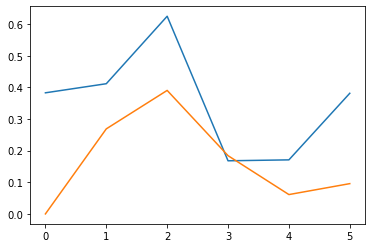

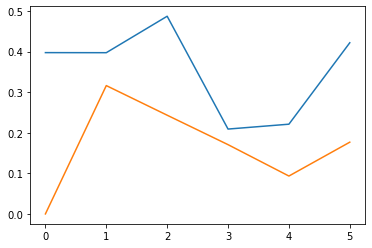

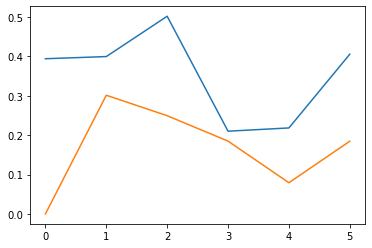

In [37]:
for dim_pc, dim_mean_pc in zip(dims_pc, dims_mean_pc):
    plt.figure()
    plt.plot(dim_pc)
    plt.plot(dim_mean_pc)